In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from copy import deepcopy
from bisect import bisect_left
import torch.nn as nn
import torch
import time
from collections import defaultdict

from lobio.lob.limit_order import Order, AMOUNT_TICK, PRICE_TICK, EventType, OrderType, TraderId, Side
from lobio.lob.order_book import  OrderBook, OrderBookSimple, OrderBookSimple2
from lobio.utils.utils import group_diffs, group_historical_trades, group_orders, get_initial_order_book
from queue_dynamic.models.models import GaussianPDFModel, ModelPerceptron
from queue_dynamic.simulation import run_true_simulation, run_pred_simulation
from queue_dynamic.losses import reinforce_objective, reinforce_objective_with_baseline

sns.set_theme(style="darkgrid")

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [19]:
coefs = 0.99**torch.arange(0, 10)
cum_sum = torch.cumsum(coefs, dim=0)
reverse_cum_sum = coefs - cum_sum + cum_sum[-1]

In [28]:
reverse_cum_sum / 0.99**torch.arange(0, 10)

tensor([9.5618, 8.6483, 7.7255, 6.7935, 5.8520, 4.9010, 3.9404, 2.9701, 1.9900,
        1.0000])

In [2]:
# diffs_raw_file = "../data/diffs_raw.npy"
# init_lob_raw_file = "../data/init_lob_raw.npy"
# aggtrades_raw_file = "../data/aggtrades_raw.npy"

diffs_prepared_file = "../data/diffs_prepared.npy"
init_lob_prepared_file = "../data/init_lob_prepared.npy"
orders_prepared_file = "../data/orders_prepared.npy"
pl_to_enter_file = "../data/price_level_to_enter.npy"

# with open(init_lob_raw_file, 'rb') as file:
#     init_lob_raw = np.load(file)
# with open(diffs_raw_file, 'rb') as file:
#     diffs_raw = np.load(file)
# with open(aggtrades_raw_file, 'rb') as file:
#     aggtrades_raw = np.load(file)

with open(init_lob_prepared_file, 'rb') as file:
    init_lob = np.load(file)
with open(diffs_prepared_file, 'rb') as file:
    diffs = np.load(file)
with open(orders_prepared_file, 'rb') as file:
    orders = np.load(file)

with open(pl_to_enter_file, 'rb') as file:
    pl_to_enter = np.load(file)

In [3]:
diffs_grouped = group_diffs(diffs)
orders_per_diff = group_orders(orders, len(diffs_grouped))
n_poses = len(pl_to_enter)

100%|██████████| 23209/23209 [00:00<00:00, 83089.87it/s]


In [4]:
len(orders_per_diff), len(diffs_grouped), n_poses

(23209, 23209, 4120)

In [5]:
with open('../experiments/exp3/hypers.pkl', 'rb') as f:
    params = pickle.load(f)

In [6]:
params

{'dim_obs': 2,
 'dim_act': 1,
 'dim_hid': 8,
 'n_hid_layers': 1,
 'std': 0.01,
 'scale_factor': 1,
 'gamma': 0.95,
 'lr': 0.01,
 'N_iter': 50,
 'N_episod': 500,
 'n_exp': 10}

# REINFORCE

In [7]:
dim_observation = 3
dim_action = 1
dim_hidden = 8
n_hidden_layers = 1
std = 0.01
scale_factor = 10
gamma = 0.95
lr = 0.001
N_iter = 50
N_episode = 500
n_exp = 10

In [12]:
seed = int(round(np.random.uniform(0, 10), 5) * 10**5)
torch.manual_seed(seed)
rng = np.random.default_rng(seed)

agent_network = ModelPerceptron(dim_observation, dim_action, dim_hidden=dim_hidden, n_hidden_layers=n_hidden_layers)
rl_model = GaussianPDFModel(
    model=agent_network,
    dim_observation=dim_observation,
    dim_action=dim_action,
    action_bounds=np.array([[0, 1]]),
    scale_factor=scale_factor,
    std=std,
)
optimizer = torch.optim.SGD(rl_model.parameters(), lr=lr)

In [13]:
running_loss = []
running_reward = []
baseline = torch.FloatTensor([])
for i in tqdm(range(N_iter)):
    samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
    samples_ind.sort()
    samples = pl_to_enter[samples_ind]
    place_ratios = np.zeros(len(samples))

    optimizer.zero_grad()
    poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
    poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_model)
    loss, reward = reinforce_objective(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma)
    running_loss.append(loss.item())
    running_reward.append(reward)

    loss.backward()
    optimizer.step()
    #scheduler.step()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:47<00:00,  5.75s/it]


In [14]:
with torch.no_grad():
    samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
    samples_ind.sort()
    samples = pl_to_enter[samples_ind]
    place_ratios = np.zeros(len(samples))#rng.uniform(0, 0.3, size=len(samples))#rng.triangular(0, 0.1, 1, size=len(samples))
    poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
    poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_model)
    loss, reward = reinforce_objective(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma)

print(reward)

0.9745454545454545


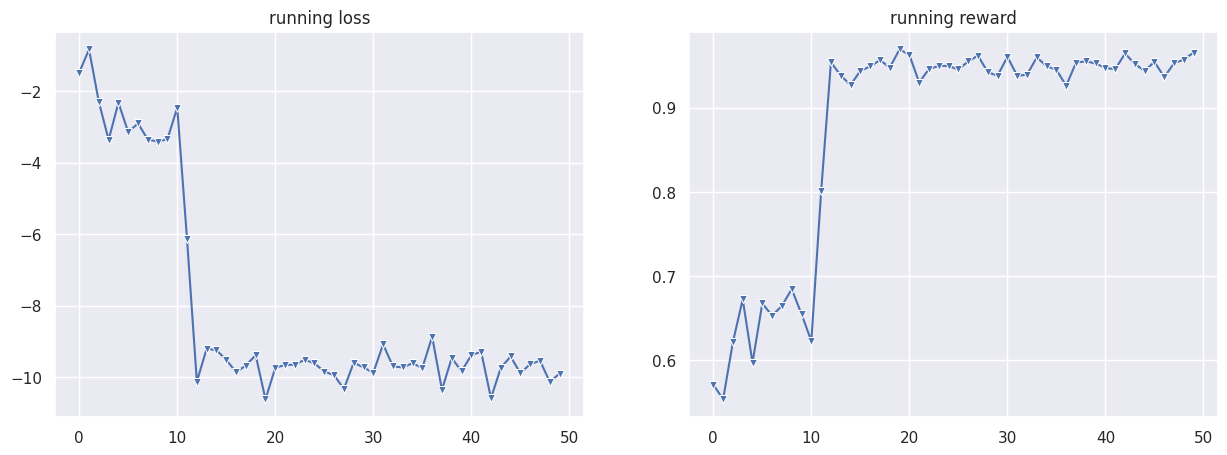

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(running_loss, marker='v', ax=axes[0])
axes[0].set_title('running loss')

sns.lineplot(running_reward, marker='v', ax=axes[1])
axes[1].set_title('running reward')

plt.show()

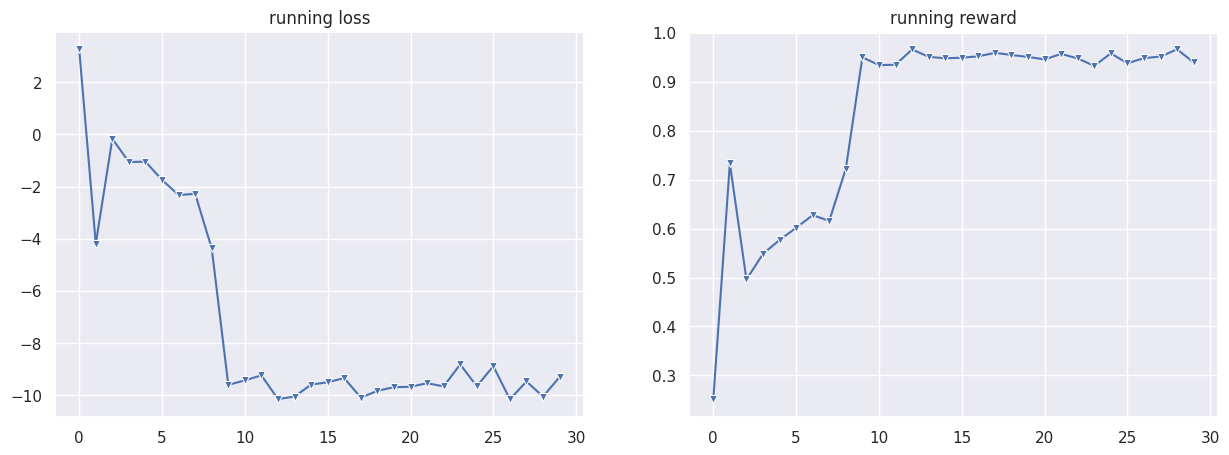

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(running_loss, marker='v', ax=axes[0])
axes[0].set_title('running loss')

sns.lineplot(running_reward, marker='v', ax=axes[1])
axes[1].set_title('running reward')

plt.show()

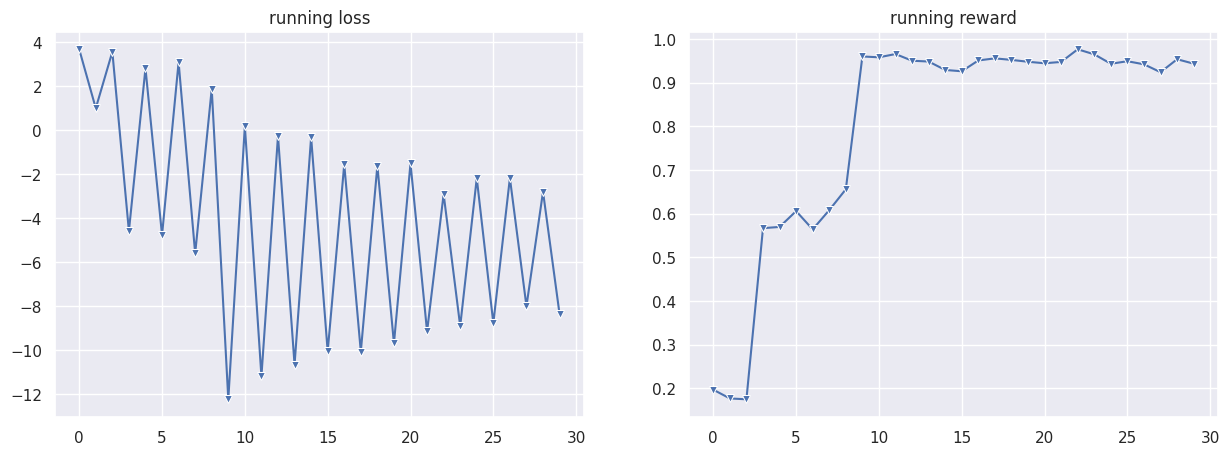

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(running_loss, marker='v', ax=axes[0])
axes[0].set_title('running loss')

sns.lineplot(running_reward, marker='v', ax=axes[1])
axes[1].set_title('running reward')

plt.show()

In [26]:
params = {'dim_obs': dim_observation, 
          'dim_act': dim_action, 
          'dim_hid': dim_hidden,
          'n_hid_layers': n_hidden_layers,
          'std': std, 
          'scale_factor': scale_factor,
          'gamma': gamma,
          'lr': lr,
          'N_iter': N_iter,
          'N_episod': N_episode,
          'n_exp': n_exp
          }
seeds = []
running_losses = []
running_rewards = []

for _ in range(n_exp):
    seed = int(round(np.random.uniform(0, 10), 5) * 10**5)
    torch.manual_seed(seed)
    rng = np.random.default_rng(seed)
    seeds.append(seed)

    model_perc = ModelPerceptron(dim_observation, dim_action, dim_hidden=dim_hidden, n_hidden_layers=n_hidden_layers)
    rl_model = GaussianPDFModel(
        model=model_perc,
        dim_observation=dim_observation,
        dim_action=dim_action,
        action_bounds=np.array([[0, 1]]),
        scale_factor=scale_factor,
        std=std,
    )
    optimizer = torch.optim.SGD(rl_model.parameters(), lr=lr)

    running_loss = []
    running_reward = []
    for i in tqdm(range(N_iter)):
        #samples = rng.choice(pl_to_enter, size=1000, replace=False, axis=0)
        samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
        samples_ind.sort()
        samples = pl_to_enter[samples_ind]
        place_ratios = np.zeros(len(samples))#rng.uniform(0, 0.3, size=len(samples))#rng.triangular(0, 0.1, 1, size=len(samples))

        optimizer.zero_grad()
        poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
        poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_model)
        loss, reward = reinforce_objective(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma)
        running_loss.append(loss.item())
        running_reward.append(reward)

        loss.backward()
        optimizer.step()

    running_losses.append(running_loss)
    running_rewards.append(running_reward)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:52<00:00,  3.74s/it]


In [28]:
save_dir = f'../experiments/exp{101}/'
with open(save_dir + 'hypers.pkl', 'wb') as f:
    pickle.dump(params, f)
with open(save_dir + 'seeds.npy', 'wb') as f:
    np.save(f, seeds)
with open(save_dir + 'losses.npy', 'wb') as f:
    np.save(f, running_losses)
with open(save_dir + 'rewards.npy', 'wb') as f:
    np.save(f, running_rewards)

In [404]:
save_dir = f'../experiments/exp{15}/'
with open(save_dir + 'hypers.pkl', 'rb') as f:
    params = pickle.load(f)
with open(save_dir + 'seeds.npy', 'rb') as f:
    seeds = np.load(f)
with open(save_dir + 'losses.npy', 'rb') as f:
    losses = np.load(f)
with open(save_dir + 'rewards.npy', 'rb') as f:
    rewards = np.load(f)

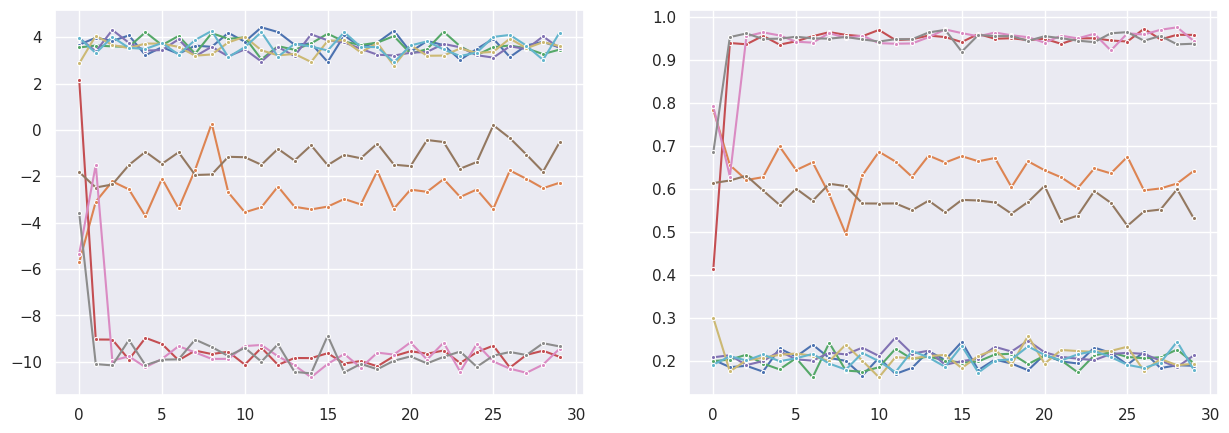

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, loss in enumerate(running_losses):
    sns.lineplot(loss, marker='.', ax=axes[0])
    # plt.savefig(save_dir + f'loss{i+1}')
    # plt.cla()
for i, reward in enumerate(running_rewards):
    sns.lineplot(reward, marker='.', ax=axes[1])
    # plt.savefig(save_dir + f'loss{i+1}')
    # plt.cla()
plt.savefig(save_dir + f'loss_reward_all')

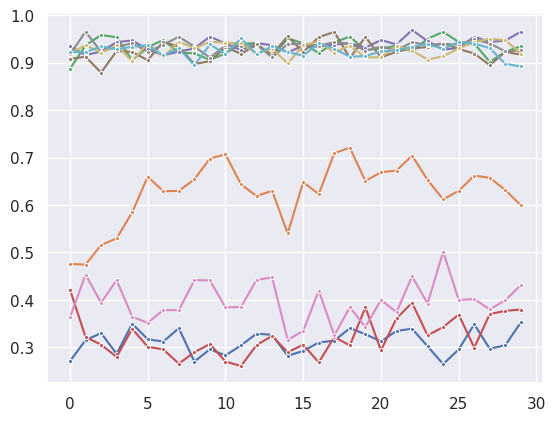

In [406]:
for i, loss in enumerate(rewards):
    sns.lineplot(loss, marker='.')
    # plt.savefig(save_dir + f'reward{i+1}')
    # plt.cla()
plt.savefig(save_dir + f'reward_all')

In [407]:
loss_df = pd.DataFrame({'loss': losses.reshape(-1, ), 'iter': np.tile(np.arange(losses.shape[1]), losses.shape[0])})
reward_df = pd.DataFrame({'reward': rewards.reshape(-1, ), 'iter': np.tile(np.arange(rewards.shape[1]), rewards.shape[0])})

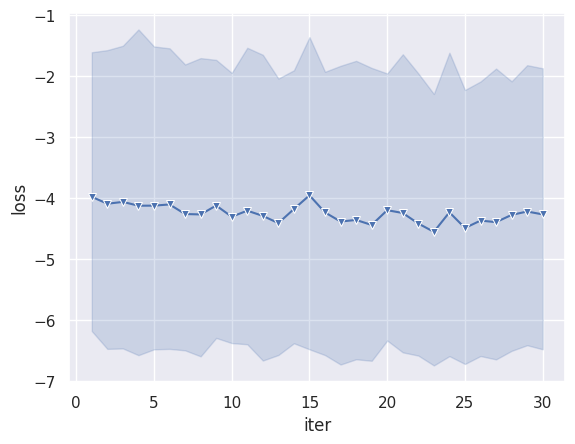

In [408]:
sns.lineplot(loss_df, marker='v', x='iter', y='loss')
plt.savefig(save_dir + 'loss_avg')
plt.show()

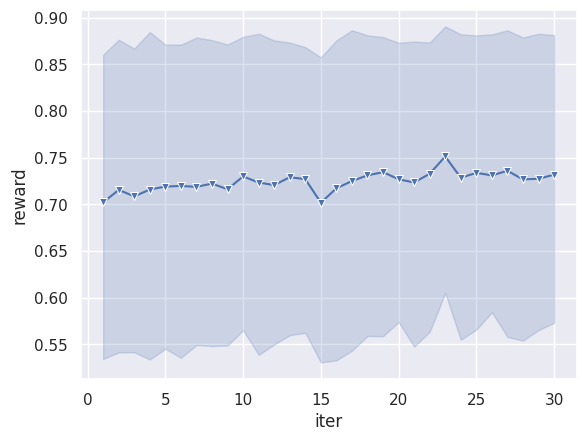

In [409]:
sns.lineplot(reward_df, marker='v', x='iter', y='reward')
plt.savefig(save_dir + 'reward_avg')
plt.show()